In [36]:
%pip install opencv-python scikit-image scipy tqdm

Note: you may need to restart the kernel to use updated packages.


In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import ndimage as ndi
from skimage.measure import label
from skimage.segmentation import watershed, mark_boundaries


In [38]:
DATASET_PATH = "stage1_train"

image_ids = os.listdir(DATASET_PATH)

print("Total samples:", len(image_ids))


Total samples: 670


**Load Sample (Instance Aware)**

In [39]:
def load_sample(sample_id):

    sample_path = os.path.join(DATASET_PATH, sample_id)

    # Load image
    img_path = os.path.join(sample_path, "images")
    img_file = os.listdir(img_path)[0]
    img = cv2.imread(os.path.join(img_path, img_file))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load masks
    mask_path = os.path.join(sample_path, "masks")
    mask_files = os.listdir(mask_path)

    combined_mask = np.zeros_like(img_gray, dtype=np.uint8)
    instance_mask = np.zeros_like(img_gray, dtype=np.int32)

    for i, mask_file in enumerate(mask_files):

        mask = cv2.imread(os.path.join(mask_path, mask_file), 0)
        mask_binary = (mask > 0).astype(np.uint8)

        combined_mask = np.maximum(combined_mask, mask_binary)
        instance_mask[mask_binary == 1] = i + 1

    return img, img_gray, combined_mask, instance_mask


**Watershed Pipeline**

In [40]:
def watershed_pipeline(img_gray, use_markers=True):

    # Normalize
    img_norm = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        img_norm,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        51,
        2
    )

    thresh = cv2.bitwise_not(thresh)

    # Remove small noise
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Distance transform
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    if use_markers:

        # Strong foreground
        dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
        _, sure_fg = cv2.threshold(dist_norm, 0.4, 1.0, cv2.THRESH_BINARY)
        sure_fg = (sure_fg > 0).astype(np.uint8)

        markers = label(sure_fg)

    else:
        markers = label(thresh)

    labels_ws = watershed(-dist, markers, mask=thresh)

    return labels_ws


**Visualization**

In [41]:
def visualize_colored(img, gt_mask, ws_basic, ws_marker):

    # Convert watershed markers to positive labels
    basic_labels = ws_basic.copy()
    marker_labels = ws_marker.copy()

    basic_labels[basic_labels <= 1] = 0
    marker_labels[marker_labels <= 1] = 0

    fig, axes = plt.subplots(1, 4, figsize=(18,4))

    # Original
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Ground Truth
    axes[1].imshow(gt_mask, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Watershed without markers (colored)
    axes[2].imshow(basic_labels, cmap='tab20')
    axes[2].set_title(f"No Marker\nRegions: {len(np.unique(basic_labels)) - 1}")
    axes[2].axis("off")

    # Marker-controlled watershed (colored)
    axes[3].imshow(marker_labels, cmap='tab20')
    axes[3].set_title(f"Marker-Controlled\nRegions: {len(np.unique(marker_labels)) - 1}")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


**Test on one Image**

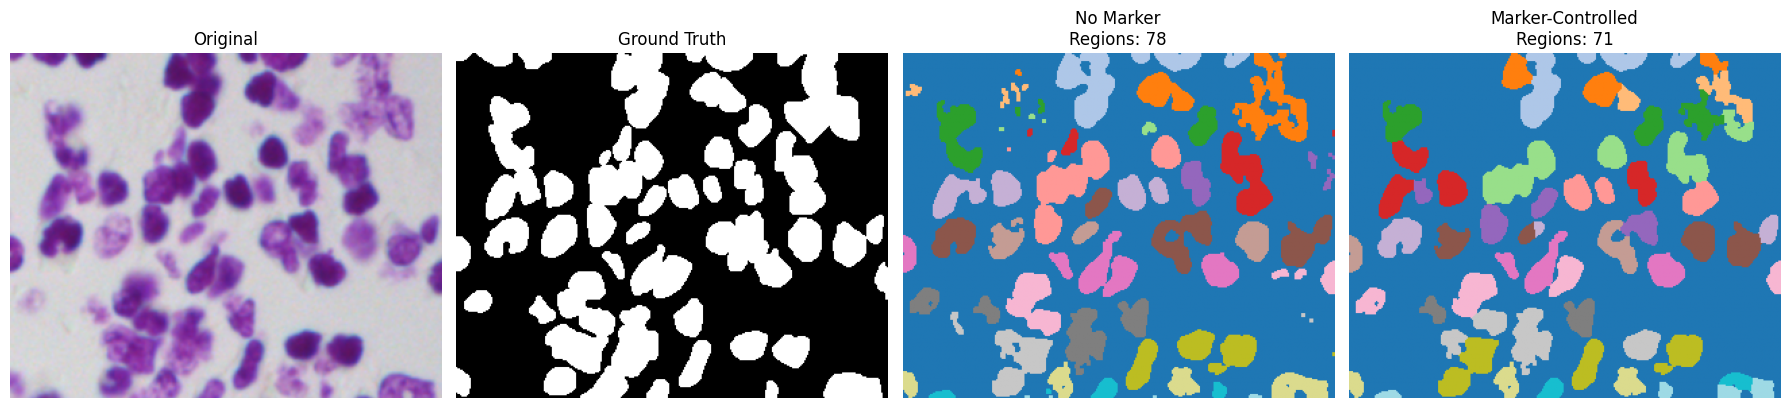

In [47]:
img, img_gray, gt_mask, instance_mask = load_sample(image_ids[2])

ws_basic = watershed_pipeline(img_gray, use_markers=False)
ws_marker = watershed_pipeline(img_gray, use_markers=True)

visualize_colored(img, gt_mask, ws_basic, ws_marker)


**Counting Function**

In [43]:
def count_nuclei(label_img):
    return len(np.unique(label_img)) - 1

**Quantitative Evaluation**

In [44]:
basic_counts = []
marker_counts = []
gt_counts = []

for sample_id in tqdm(image_ids[:100]):

    img, img_gray, gt_mask, instance_mask = load_sample(sample_id)

    ws_basic = watershed_pipeline(img_gray, use_markers=False)
    ws_marker = watershed_pipeline(img_gray, use_markers=True)

    basic_counts.append(count_nuclei(ws_basic))
    marker_counts.append(count_nuclei(ws_marker))
    gt_counts.append(count_nuclei(instance_mask))


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


In [45]:
print("===== FINAL RESULTS =====")

print("Average GT nuclei:", np.mean(gt_counts))
print("Average Without Markers:", np.mean(basic_counts))
print("Average With Markers:", np.mean(marker_counts))

print("\nOver-segmentation ratio (No Marker):",
      np.mean(basic_counts) / np.mean(gt_counts))

print("Over-segmentation ratio (Marker-Controlled):",
      np.mean(marker_counts) / np.mean(gt_counts))


===== FINAL RESULTS =====
Average GT nuclei: 48.55
Average Without Markers: 144.63
Average With Markers: 81.78

Over-segmentation ratio (No Marker): 2.9789907312049433
Over-segmentation ratio (Marker-Controlled): 1.6844490216271886
